## This Notebook use a resamping method (permutation + bootstrap) to generate a global confidence interval and check wether a the rotarod performance is different between two groups of animals

### This non-parametric method alleviates many concerns in traditional statistical hypothesis tests, such as distribution assumptions (e.g., normality assumption under analysis of variance), error inflation due to multiple comparisons, and sensitivity to unbalanced


## <span style="color:darkred"> 1. Load libraries 

In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import math
#import seaborn as sns
import matplotlib.cm as cm 
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit


#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))

## Rotarod performance consists in the time at which mice placed on an accelerating rotarod fall. Each animal perform 10 trials per day for 5 days.


## <span style="color:darkred"> 3. Access the data locally (Notebook)

In [3]:
path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ExternCollab/CelanieData'
os.chdir(path_to_data_folder)
#this above is only if you run the notebook on your computer, not on collab in content directory
# excelFilename='Dr1-Dr2distributionvertical.xlsx'
# sheetNames=['DRD1','A2A']
print('you are here: ' + os.getcwd())
print('and the files in your directory are:')  
files = os.listdir(path_to_data_folder)
print(files)

you are here: /Users/davidrobbe/Documents/Science/Data/ExternCollab/CelanieData
and the files in your directory are:
['Raw data-C7-4 D2S2 simpl.xlsx', 'Raw data-C4-3 D3S2 simpl.xlsx', 'Raw data-C8-1 D3S1 simpl.xlsx']


In [4]:
excelFileNames=[]
for file in glob.glob('*.xlsx'):
        print(file)
        excelFileNames.append(file)

Raw data-C7-4 D2S2 simpl.xlsx
Raw data-C4-3 D3S2 simpl.xlsx
Raw data-C8-1 D3S1 simpl.xlsx


In [6]:
for file in glob.glob('*.xlsx'):
    new_name = file.replace(' ', '_')
    os.rename(file, new_name)
    print(f'Renamed: {file} → {new_name}')

Renamed: Raw data-C7-4 D2S2 simpl.xlsx → Raw_data-C7-4_D2S2_simpl.xlsx
Renamed: Raw data-C4-3 D3S2 simpl.xlsx → Raw_data-C4-3_D3S2_simpl.xlsx
Renamed: Raw data-C8-1 D3S1 simpl.xlsx → Raw_data-C8-1_D3S1_simpl.xlsx


In [7]:
excelFileNames=[]
for file in glob.glob('*.xlsx'):
        print(file)
        excelFileNames.append(file)

Raw_data-C7-4_D2S2_simpl.xlsx
Raw_data-C4-3_D3S2_simpl.xlsx
Raw_data-C8-1_D3S1_simpl.xlsx


In [50]:
file_path = os.path.join(path_to_data_folder, excelFileNames[2])
print(file_path)

/Users/davidrobbe/Documents/Science/Data/ExternCollab/CelanieData/Raw_data-C8-1_D3S1_simpl.xlsx


In [51]:
# Load the file and skip header lines
df = pd.read_excel(file_path, sheet_name='Track-Arena 1-Subject 1', skiprows=38, header=None)

# Rename relevant columns
df = df[[1, 2, 3]]  # Assuming columns: 0 = time, 2 = X, 3 = Y
df.columns = ['Recording Time', 'X Center', 'Y Center']

print(df.head())

   Recording Time  X Center  Y Center
0            0.04 -0.660618  0.450406
1            0.08 -0.655435  0.453862
2            0.12 -0.628315  0.441394
3            0.16 -0.628472  0.446608
4            0.20 -0.631778  0.437638


In [43]:
# Extract time and positions from the DataFrame
time_video_frames = df['Recording Time'].to_numpy()
xpositions = df['X Center'].to_numpy()
ypositions = df['Y Center'].to_numpy()

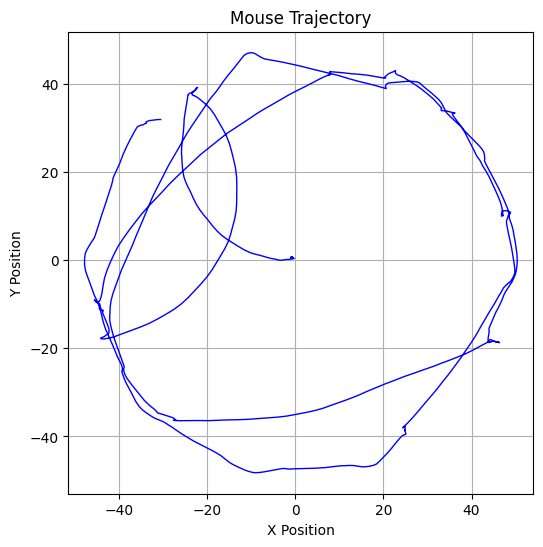

In [52]:
# Replace non-numeric entries with NaN and drop them
df_clean = df.copy()
df_clean['Recording Time'] = pd.to_numeric(df_clean['Recording Time'], errors='coerce')
df_clean['X Center'] = pd.to_numeric(df_clean['X Center'], errors='coerce')
df_clean['Y Center'] = pd.to_numeric(df_clean['Y Center'], errors='coerce')

# Drop rows with any NaN
df_clean = df_clean.dropna(subset=['Recording Time', 'X Center', 'Y Center'])

# Extract clean arrays
time_video_frames = df_clean['Recording Time'].to_numpy()
xpositions = df_clean['X Center'].to_numpy()
ypositions = df_clean['Y Center'].to_numpy()


# Plot
plt.figure(figsize=(6, 6))
plt.plot(xpositions, ypositions, color='blue', linewidth=1)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Mouse Trajectory')
plt.axis('equal')
plt.grid(True)
plt.show()

In [53]:
# Smoothing parameter
smooth_sigma = 1
# Smooth positions
smoothed_Xpositions = gaussian_filter1d(xpositions, sigma=smooth_sigma)
smoothed_Ypositions = gaussian_filter1d(ypositions, sigma=smooth_sigma)

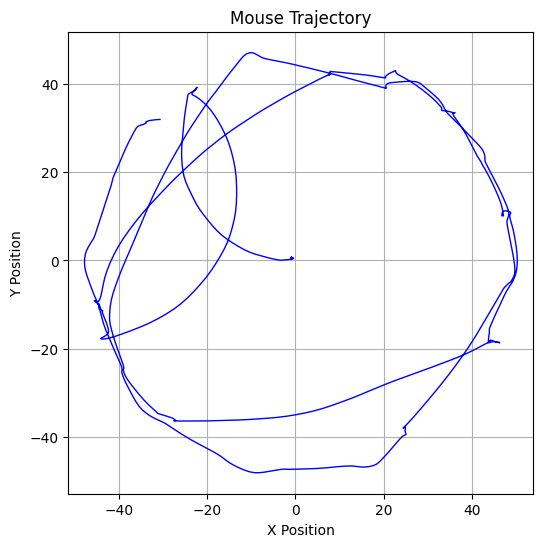

In [54]:
# Plot
plt.figure(figsize=(6, 6))
plt.plot(smoothed_Xpositions, smoothed_Ypositions, color='blue', linewidth=1)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Mouse Trajectory')
plt.axis('equal')
plt.grid(True)
plt.show()

In [55]:


# ### Function to compute distance, speed, and angular speed in degrees per second.
# #### We only compute angular speed when mice is moving above a certain speed threshold in cm/s

def compute_distance_speed_angular_speed(smoothed_positions, time_video_frames, speed_threshold=5):
    # Calculate the differences between consecutive points
    delta_x = np.diff(smoothed_positions[0])
    delta_y = np.diff(smoothed_positions[1])
    delta_t = np.diff(time_video_frames)

    # Compute the distances traveled between each timepoint
    distances = np.sqrt(delta_x**2 + delta_y**2)

    speeds = distances / delta_t
    smooth_sigma = 1 #the sigma used for the remaining of the analysis for smoothing
    speeds = gaussian_filter1d(speeds, sigma=smooth_sigma)

    # Compute the angles between each timepoint
    angles = np.arctan2(delta_y, delta_x)

    # Compute the differences between consecutive angles
    delta_angles = np.diff(angles)

    # Convert delta_angles from radians to degrees
    delta_angles_deg = np.degrees(delta_angles)

    # Ensure angles are within -180 to 180 range
    delta_angles_deg = (delta_angles_deg + 180) % 360 - 180

    # Mask speeds below the threshold
    valid_mask = speeds > speed_threshold

    # Compute angular speeds in degrees per second
    angular_speeds = np.zeros_like(delta_angles_deg)
    valid_delta_t = delta_t[1:][valid_mask[1:]]
    angular_speeds[valid_mask[1:]] = delta_angles_deg[valid_mask[1:]] / valid_delta_t

    # Filter angular speeds to include only those above the threshold
    filtered_angular_speeds = angular_speeds[valid_mask[1:]]

    # Get the times corresponding to filtered angular speeds
    # filtered_times = time_video_frames[1:][valid_mask[1:]]

    # Create a structured output with angular speeds and corresponding times
    # angular_speeds_with_times = list(zip(filtered_times, filtered_angular_speeds))

    distances= np.insert(distances, 0, 0) # insert a 0 to avoid length error with  time_video_frames. We consider that
                                        # at the first frame the distance is null
    speeds = np.insert(speeds, 0, 0) # insert a 0 to avoid length error with time_video_frames. We consider that
                                        # at the first frame the speed is null


    return distances, speeds, filtered_angular_speeds

In [56]:
# Combine smoothed positions in cm
smoothed_positions = [smoothed_Xpositions, smoothed_Ypositions]
distances, speeds, filtered_angular_speeds = compute_distance_speed_angular_speed(smoothed_positions, time_video_frames, speed_threshold=5)

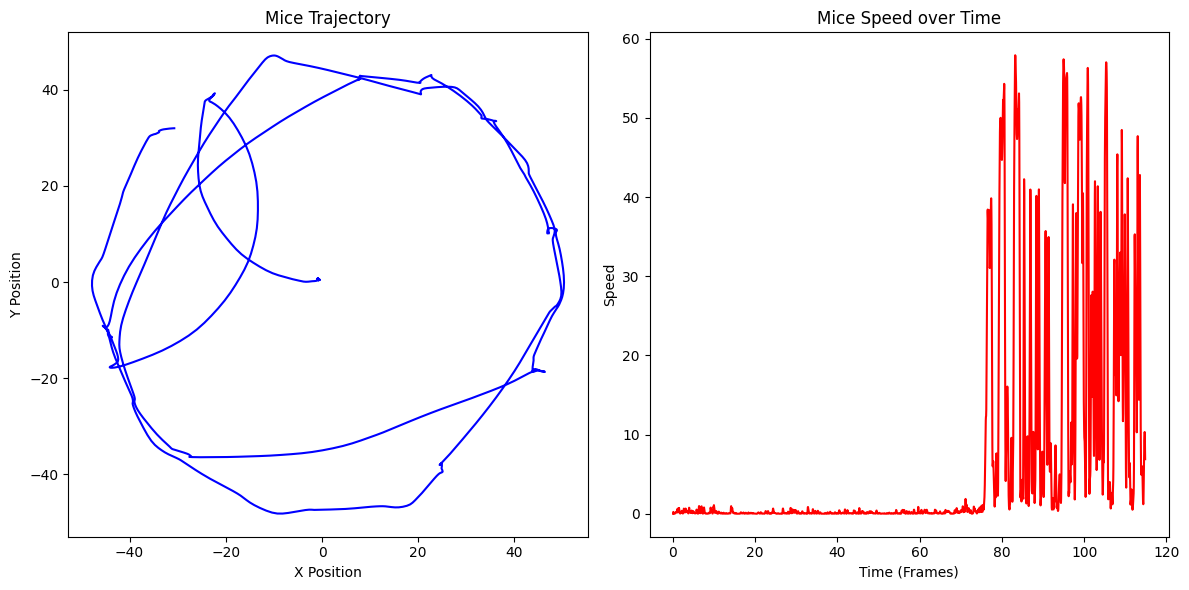

In [57]:
# Create a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot trajectory
ax[0].plot(smoothed_Xpositions, smoothed_Ypositions, color='b', label='Trajectory')
ax[0].set_xlabel('X Position')
ax[0].set_ylabel('Y Position')
ax[0].set_title('Mice Trajectory')
ax[0].axis('equal')  # Equal scaling on both axes

# Plot speed over time
ax[1].plot(time_video_frames, speeds, color='r', label='Speed')
ax[1].set_xlabel('Time (Frames)')
ax[1].set_ylabel('Speed')
ax[1].set_title('Mice Speed over Time')

# Show the plot
plt.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (2621,) and (2622,)

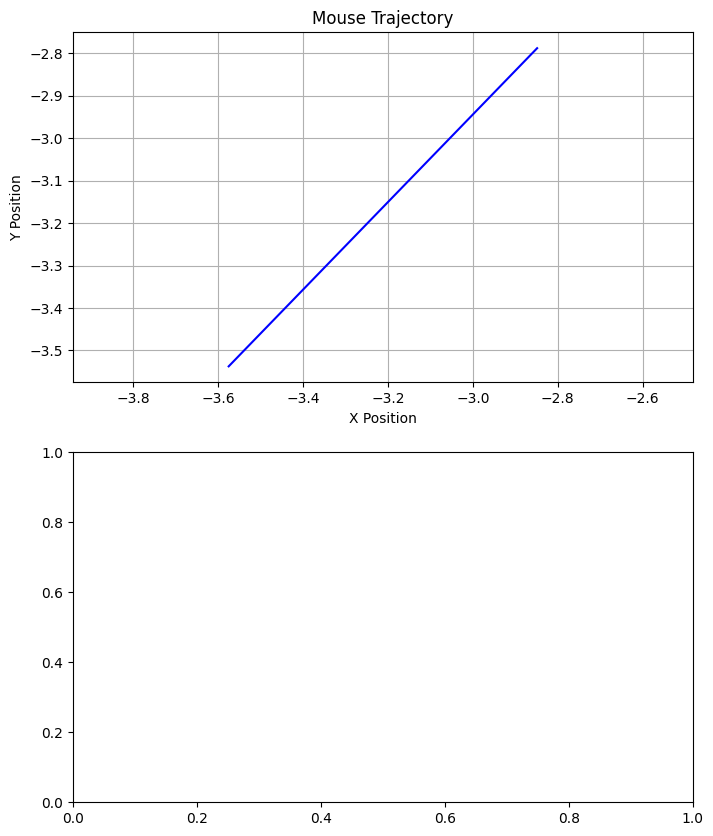

In [ ]:
# Create a figure with two subplots (vertical layout)
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=False)
smoothed_positions = np.array(smoothed_positions)
# Plot trajectory
axs[0].plot(smoothed_positions[:, 0], smoothed_positions[:, 1], color='blue')
axs[0].set_title('Mouse Trajectory')
axs[0].set_xlabel('X Position')
axs[0].set_ylabel('Y Position')
axs[0].axis('equal')
axs[0].grid(True)

# Plot speed
axs[1].plot(time_video_frames[1:], speeds, color='green')
axs[1].set_title('Instantaneous Speed')
axs[1].set_xlabel('Time (video frames or seconds)')
axs[1].set_ylabel('Speed (units/frame)')
axs[1].grid(True)

plt.tight_layout()
plt.show()

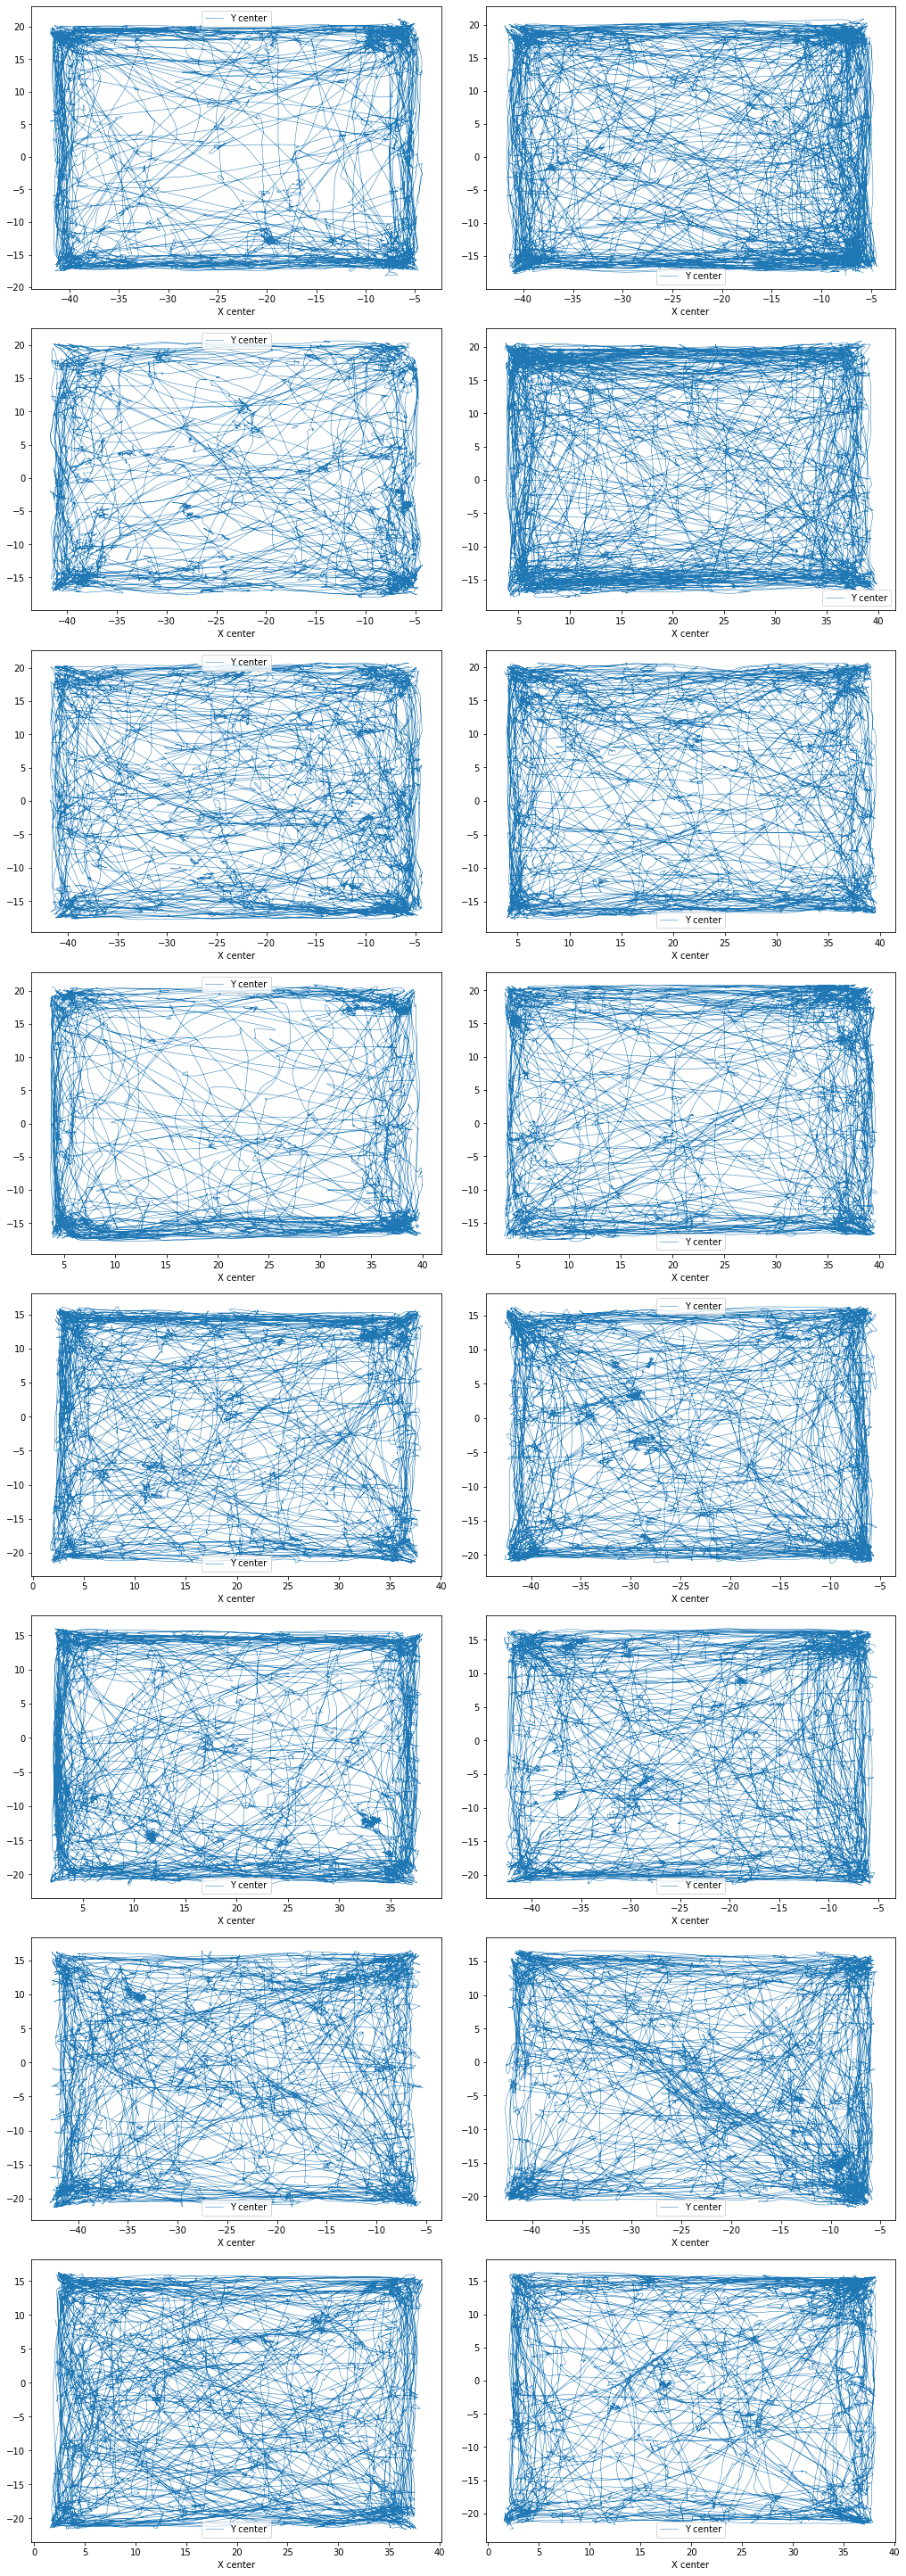

In [64]:
fig, axs = plt.subplots(ncols=2, nrows=8, figsize=(7*2, 5*8),
                        constrained_layout=True)

animalnumbergroup={}
animalnumbergroup['G1']=0
animalnumbergroup['G2']=0
for subdirectoy in directories:
    for excelfilename in glob.glob(subdirectoy+'/*.xlsx'):
        for mouseinfo in miceLabels[subdirectoy]:
            error = []
            try: 
                dataframe=pd.read_excel(excelfilename,sheet_name=mouseinfo[0], index_col=None, na_values=['-'], usecols="B:D",header=[33],engine='openpyxl')
                dataframe.drop(0, axis=0, inplace=True)
                dataframe.dropna()
                if mouseinfo[1]=='G1':
                    columnindex=0
                    animalnumbergroup['G1']+=1
                else:
                    columnindex=1
                    animalnumbergroup['G2']+=1
                dataframe.plot(x='X center',y='Y center',linewidth=0.5,ax=axs[animalnumbergroup[mouseinfo[1]]-1,columnindex])
                entry.append(micename)
            except:
                error.append(micename)    
    

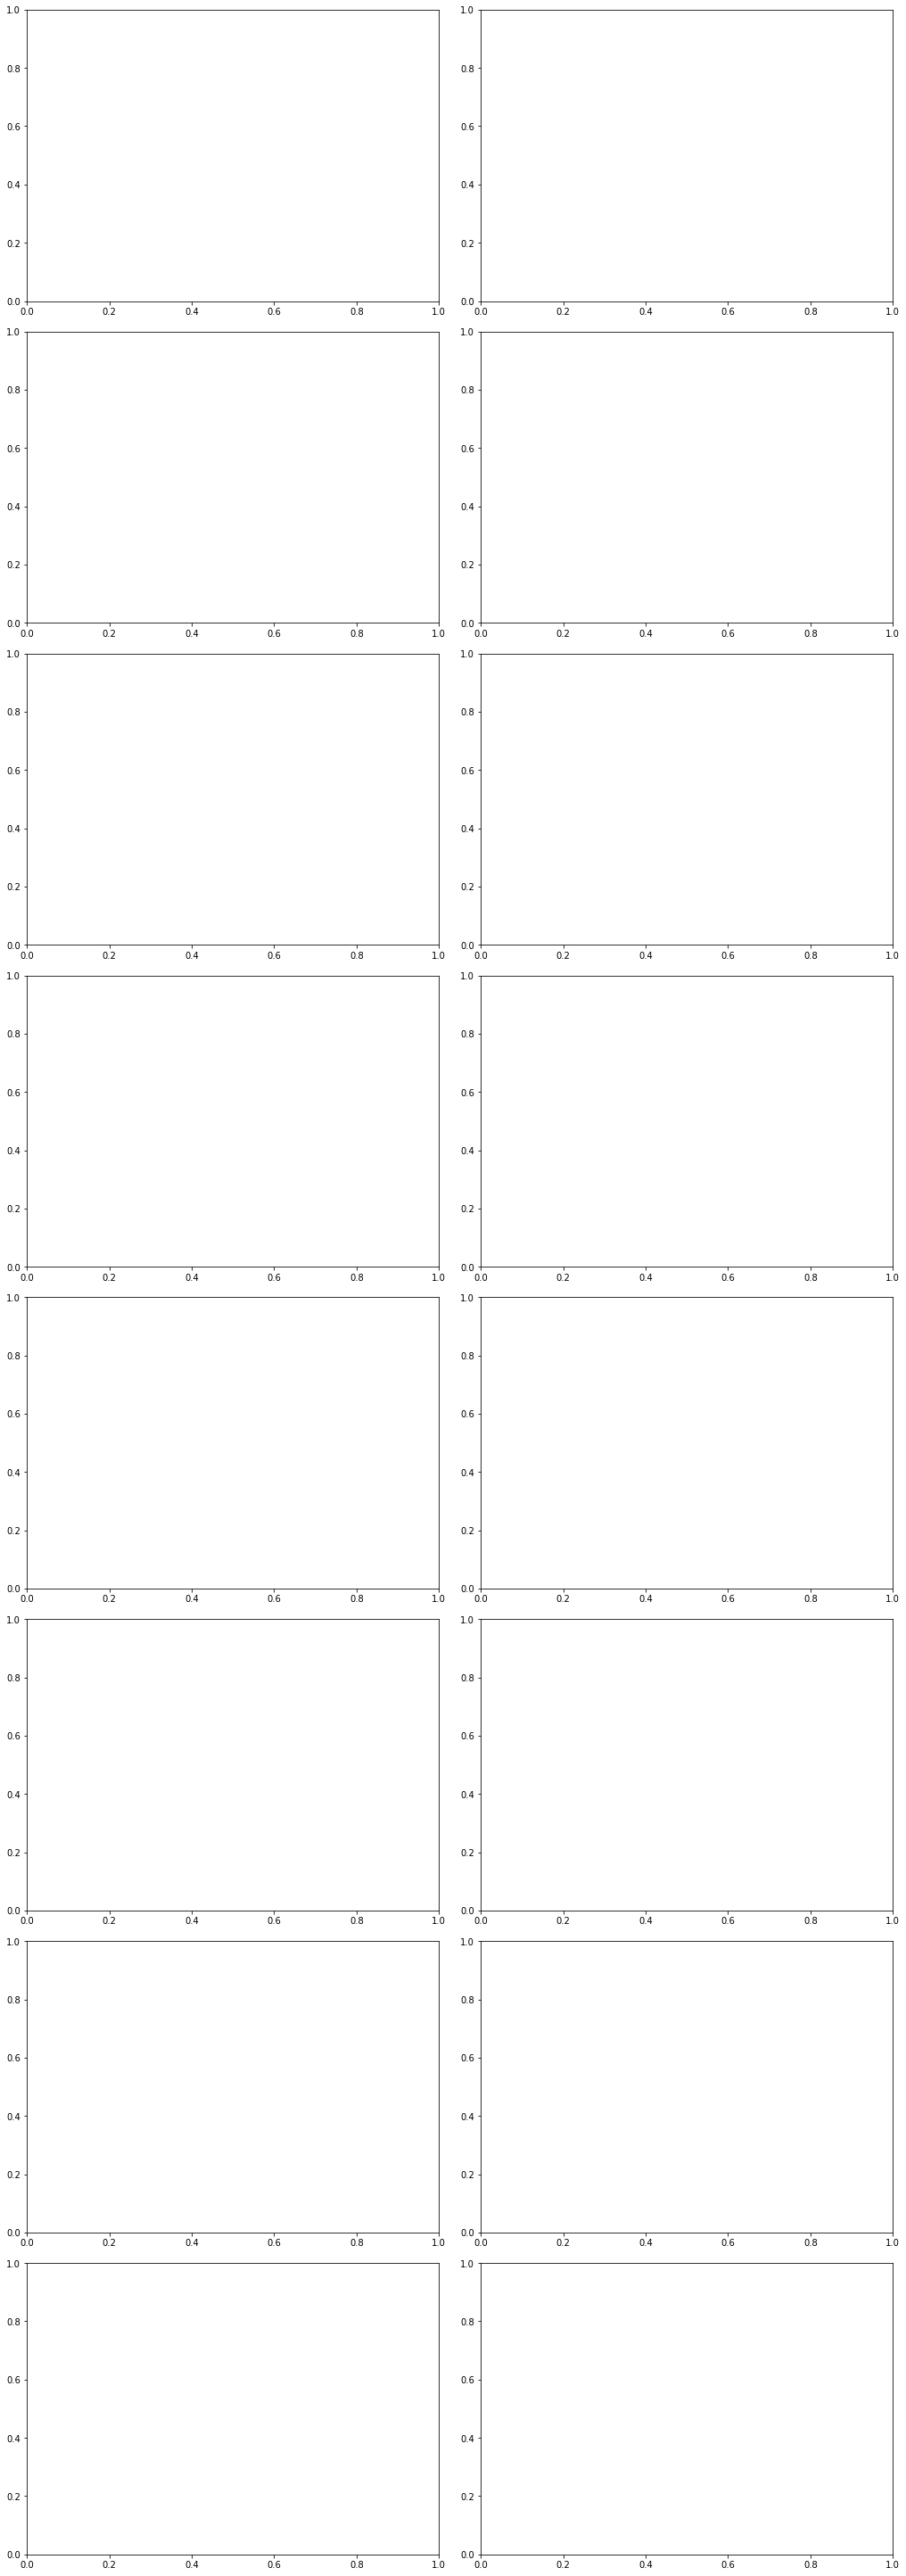

In [51]:
fig, axs = plt.subplots(ncols=2, nrows=8, figsize=(7*2, 5*8),
                        constrained_layout=True)

## <span style="color:darkred"> 4. Load the data 

### <span style="color:darkred"> as numpy array stored inside a disctionnary with names of your sheets

In [ ]:
print('check the shape of your data per experiment protocol')
alldata={}
for experimentindex, thisExperiment in enumerate(experimentsNames):
    print(experimentindex,thisExperiment)
    alldata[thisExperiment]=pd.read_excel(dataFileName,sheet_name=thisExperiment,header=[2],index_col=0).values
    print(alldata[thisExperiment].shape)
    numberoftrials=alldata[thisExperiment].shape[0]
    numberofanimaldatapoints=alldata[thisExperiment].shape[1]
    print('number of trials:  ' + str(numberoftrials))
    print('number of animals: ' + str(numberofanimaldatapoints))

check the shape of your data per experiment protocol
0 ACN
(100, 16)
number of trials:  100
number of animals: 16
1 Cst_4rpm
(101, 8)
number of trials:  101
number of animals: 8


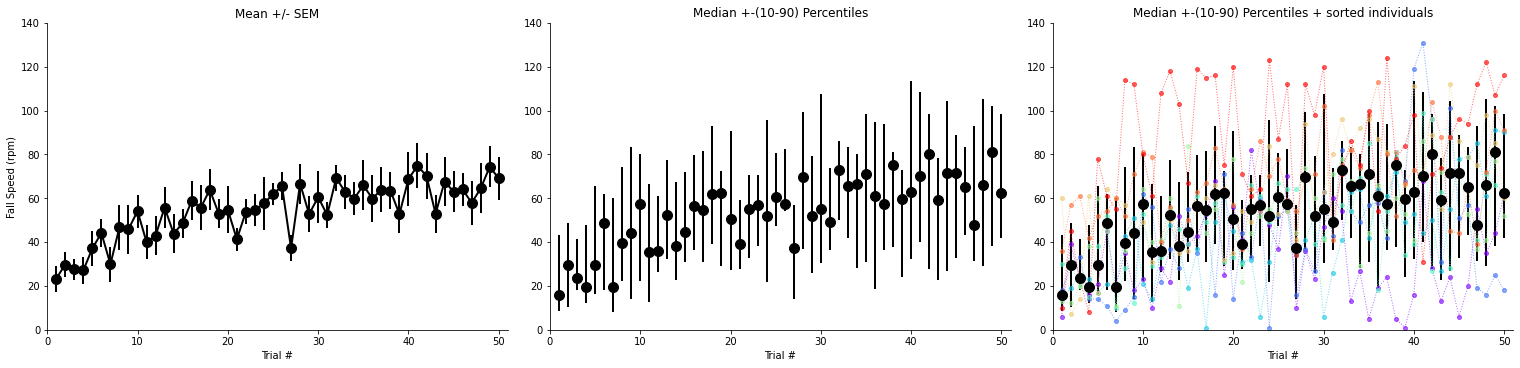

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(7*3, 5),
                        constrained_layout=True)

experimentsNames=['ACN_M']
numberoftrialstoplot=50
trialindex=np.arange(numberoftrialstoplot)
trialnumber=np.arange(1,numberoftrialstoplot+1)

alldata={}
for experimentindex, thisExperiment in enumerate(experimentsNames):

    alldata[thisExperiment]=pd.read_excel(dataFileName,sheet_name=thisExperiment,header=[2],index_col=0).values
  
    fallTimeDataThisExperiment=alldata[thisExperiment][:numberoftrialstoplot,:]
    #Classical plotting mean + SEM

    meanFallTime=np.nanmean(fallTimeDataThisExperiment,axis=1)
    semFallTime=np.nanstd(fallTimeDataThisExperiment,axis=1)/math.sqrt(numberofanimaldatapoints)
    axs[0].errorbar(trialnumber,meanFallTime,semFallTime,ecolor='k',elinewidth=2,color='k',linewidth=2,marker='o',ms=10)
    #axs[0].plot(trialnumber,np.nanmedian(alldata[thisExperiment][:,fallTimeColumnIndexes],axis=1),'k',linewidth=4)
    axs[0].set_ylim([0,140])
    axs[0].set_xlim([0,51])
    axs[0].set_title('Mean +/- SEM')
    axs[0].set_ylabel('Fall Speed (rpm)')
    axs[0].set_xlabel('Trial #')
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    #axs[0].set_xlim([trialnumber[0],trialnumber[-1]])
   

    # more appropriate plotting median+10/90 percentil
    Percentile105090=np.percentile(fallTimeDataThisExperiment,[10,50,90],axis=1)
    LowError=Percentile105090[1,:]-Percentile105090[0,:]
    HighErro=Percentile105090[2,:]-Percentile105090[1,:]
    axs[1].errorbar(trialnumber,np.nanmedian(fallTimeDataThisExperiment,axis=1),yerr=[LowError,HighErro],ecolor='k',elinewidth=2,color='k',linewidth=0,marker='o',ms=10)
    axs[1].set_xlim([0,51])
    axs[1].set_ylim([0,140])
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].set_title('Median +-(10-90) Percentiles')
    axs[1].set_xlabel('Trial #')


    # MOre appropriate plotting median+std+individual exp 
    ## We want to sort the individual mice according to their average fall time. This will allow for a nice plotting
    medianfallspeedperanimal=np.median(fallTimeDataThisExperiment,axis=0) 
    sortedanimalindexes=np.argsort(medianfallspeedperanimal)
  
    for index,sortedanimalindex in enumerate(sortedanimalindexes):
      axs[2].plot(trialnumber,fallTimeDataThisExperiment[:,sortedanimalindex],color=cm.rainbow(index/(len(sortedanimalindexes)-1)),linewidth=1,marker='o',ms=4,linestyle=':',alpha=0.6)


    Percentile2575=np.percentile(fallTimeDataThisExperiment,[25,70],axis=1)
    axs[2].errorbar(trialnumber,np.nanmedian(fallTimeDataThisExperiment,axis=1),yerr=[LowError,HighErro],ecolor='k',elinewidth=2,color='k',linewidth=0,marker='o',ms=10)
    
    axs[2].set_xlim([0,51])
    axs[2].set_ylim([0,140])

    axs[2].set_xlabel('Trial #')
    axs[2].set_title('Median +-(10-90) Percentiles + sorted individuals')
    axs[2].spines['right'].set_visible(False)
    axs[2].spines['top'].set_visible(False)

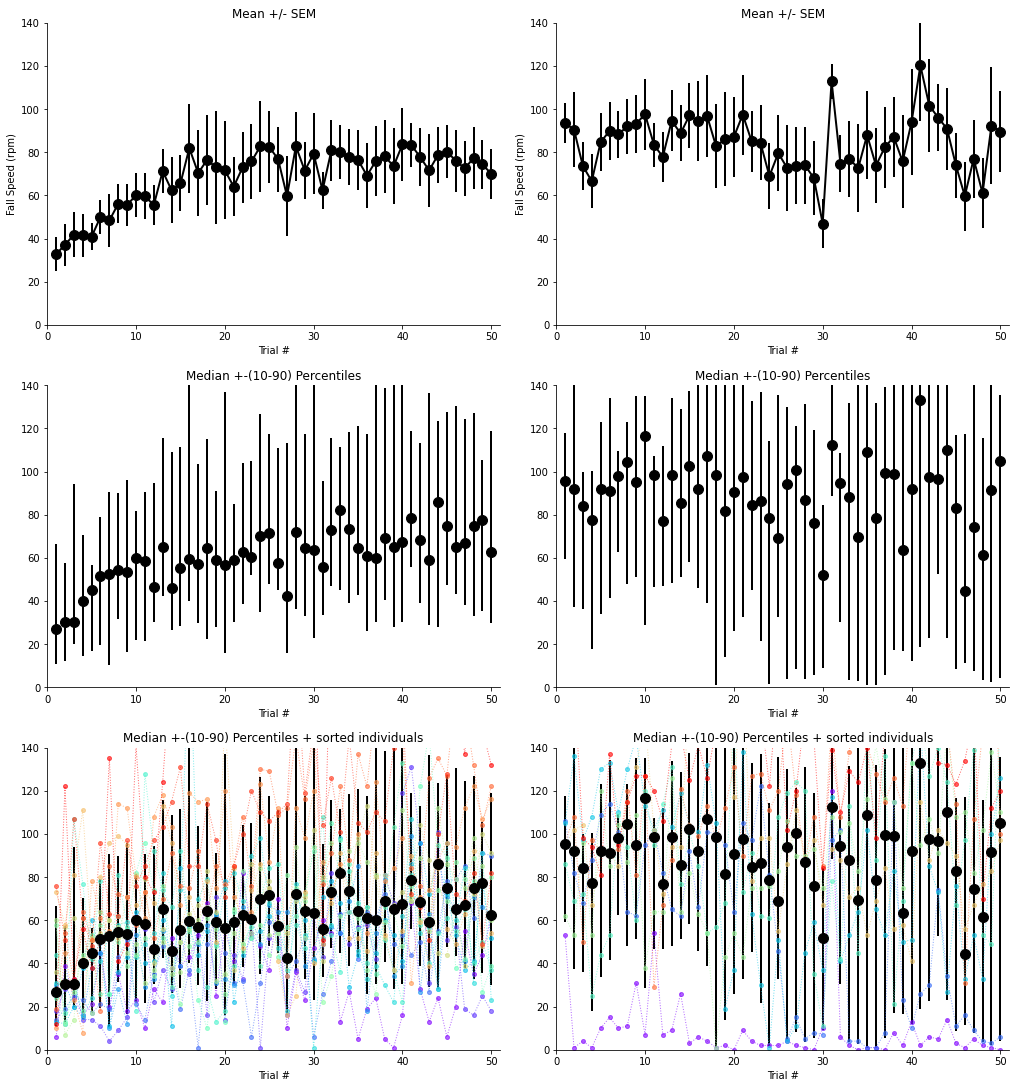

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(7*2, 5*3),
                        constrained_layout=True)

experimentsNames=['ACN_F','ACN_M']
experimentsNames=['ACN','Cst_4rpm']
numberoftrialstoplot=50
trialindex=np.arange(numberoftrialstoplot)
trialnumber=np.arange(1,numberoftrialstoplot+1)

alldata={}
for experimentindex, thisExperiment in enumerate(experimentsNames):

    alldata[thisExperiment]=pd.read_excel(dataFileName,sheet_name=thisExperiment,header=[2],index_col=0).values
  
    fallTimeDataThisExperiment=alldata[thisExperiment][:numberoftrialstoplot,:]
    #Classical plotting mean + SEM

    meanFallTime=np.nanmean(fallTimeDataThisExperiment,axis=1)
    semFallTime=np.nanstd(fallTimeDataThisExperiment,axis=1)/math.sqrt(numberofanimaldatapoints)
    axs[0,experimentindex].errorbar(trialnumber,meanFallTime,semFallTime,ecolor='k',elinewidth=2,color='k',linewidth=2,marker='o',ms=10)
    #axs[0,experimentindex].plot(trialnumber,np.nanmedian(alldata[thisExperiment][:,fallTimeColumnIndexes],axis=1),'k',linewidth=4)
    axs[0,experimentindex].set_ylim([0,140])
    axs[0,experimentindex].set_xlim([0,51])
    axs[0,experimentindex].set_title('Mean +/- SEM')
    axs[0,experimentindex].set_ylabel('Fall Speed (rpm)')
    axs[0,experimentindex].set_xlabel('Trial #')
    axs[0,experimentindex].spines['right'].set_visible(False)
    axs[0,experimentindex].spines['top'].set_visible(False)
    #axs[0,experimentindex].set_xlim([trialnumber[0],trialnumber[-1]])
   

    # more appropriate plotting median+10/90 percentil
    Percentile105090=np.percentile(fallTimeDataThisExperiment,[10,50,90],axis=1)
    LowError=Percentile105090[1,:]-Percentile105090[0,:]
    HighErro=Percentile105090[2,:]-Percentile105090[1,:]
    axs[1,experimentindex].errorbar(trialnumber,np.nanmedian(fallTimeDataThisExperiment,axis=1),yerr=[LowError,HighErro],ecolor='k',elinewidth=2,color='k',linewidth=0,marker='o',ms=10)
    axs[1,experimentindex].set_xlim([0,51])
    axs[1,experimentindex].set_ylim([0,140])
    axs[1,experimentindex].spines['right'].set_visible(False)
    axs[1,experimentindex].spines['top'].set_visible(False)
    axs[1,experimentindex].set_title('Median +-(10-90) Percentiles')
    axs[1,experimentindex].set_xlabel('Trial #')


    # MOre appropriate plotting median+std+individual exp 
    ## We want to sort the individual mice according to their average fall time. This will allow for a nice plotting
    medianfallspeedperanimal=np.median(fallTimeDataThisExperiment,axis=0) 
    sortedanimalindexes=np.argsort(medianfallspeedperanimal)
  
    for index,sortedanimalindex in enumerate(sortedanimalindexes):
      axs[2,experimentindex].plot(trialnumber,fallTimeDataThisExperiment[:,sortedanimalindex],color=cm.rainbow(index/(len(sortedanimalindexes)-1)),linewidth=1,marker='o',ms=4,linestyle=':',alpha=0.6)


    Percentile2575=np.percentile(fallTimeDataThisExperiment,[25,70],axis=1)
    axs[2,experimentindex].errorbar(trialnumber,np.nanmedian(fallTimeDataThisExperiment,axis=1),yerr=[LowError,HighErro],ecolor='k',elinewidth=2,color='k',linewidth=0,marker='o',ms=10)
    
    axs[2,experimentindex].set_xlim([0,51])
    axs[2,experimentindex].set_ylim([0,140])

    axs[2,experimentindex].set_xlabel('Trial #')
    axs[2,experimentindex].set_title('Median +-(10-90) Percentiles + sorted individuals')
    axs[2,experimentindex].spines['right'].set_visible(False)
    axs[2,experimentindex].spines['top'].set_visible(False)

## <span style="color:darkred"> 4. Compute mean for each condition, plot them and also the difference 

### <span style="color:darkred"> as numpy array stored inside a disctionnary with names of your sheets

Text(0.5, 1.0, 'difference')

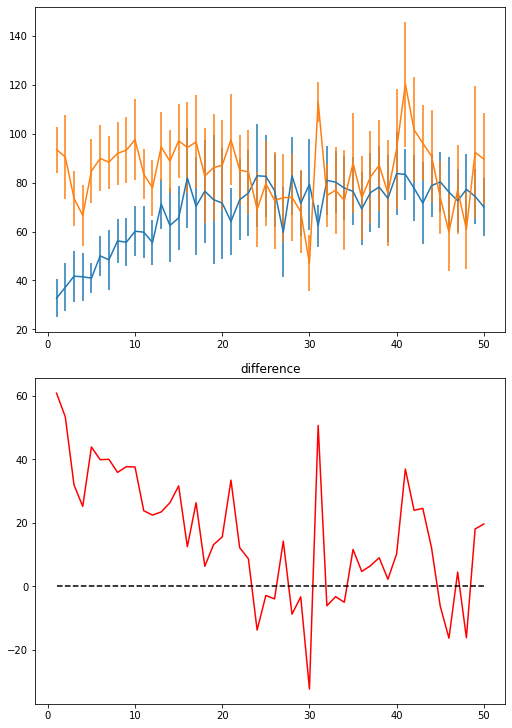

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(7*1, 5*2),
                        constrained_layout=True)

experimentsNames=['ACN_F','ACN_M']
experimentsNames=['ACN','Cst_4rpm']
numberoftrialstoplot=50
trialindex=np.arange(numberoftrialstoplot)
trialnumber=np.arange(1,numberoftrialstoplot+1)
meanpercondition=np.zeros((2,numberoftrialstoplot))
sempercondition=np.zeros((2,numberoftrialstoplot))
alldata={}
for experimentindex, thisExperiment in enumerate(experimentsNames):

    alldata[thisExperiment]=pd.read_excel(dataFileName,sheet_name=thisExperiment,header=[2],index_col=0).values
  
    fallTimeDataThisExperiment=alldata[thisExperiment][:numberoftrialstoplot,:]
    

    meanpercondition[experimentindex,:]=np.nanmean(fallTimeDataThisExperiment,axis=1)
    sempercondition[experimentindex,:]=np.nanstd(fallTimeDataThisExperiment,axis=1)/math.sqrt(numberofanimaldatapoints)
    axs[0].errorbar(trialnumber,meanpercondition[experimentindex,:],sempercondition[experimentindex,:])#,ecolor='k',elinewidth=2,color='k',linewidth=2,marker='o',ms=10)

    #axs[0].plot(trialnumber,meanpercondition[experimentindex,:])


meandifference=np.diff(meanpercondition,1,0)
axs[1].plot(trialnumber ,meandifference[0,:],color='red')
axs[1].plot([trialnumber[0],trialnumber[-1]],[0,0],'k',linestyle="--")
axs[1].set_title('difference')

## <span style="color:darkred"> 4. Permutation section
### <span style="color:darkred"> Concatenate the two data sets

In [ ]:
arrayforshuffling=np.concatenate((alldata[experimentsNames[0]][:numberoftrialstoplot,:],alldata[experimentsNames[1]][:numberoftrialstoplot,:]),axis=1)
print(arrayforshuffling.shape)

(50, 24)


### <span style="color:darkred"> generate random 1D array of 1/0 with the size of the concatenated matrix

In [ ]:
randomindexes=np.random.randint(2,size=arrayforshuffling.shape[1])
print(randomindexes)

[1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1]


### <span style="color:darkred"> find the indexes for 0 and 1 (these would be surrogate datasets)

In [ ]:
for value in [0,1]:
    index=np.where(randomindexes==value)
    print(value)
    print(index[0])

0
[ 1  2  3  5  8 10 13 14]
1
[ 0  4  6  7  9 11 12 15 16 17 18 19 20 21 22 23]


### <span style="color:darkred"> example of difference generated after permutation

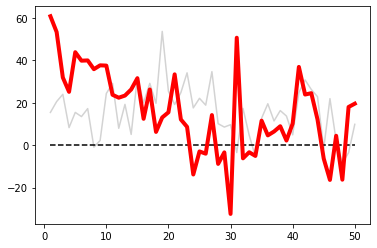

In [ ]:
randomindexes=np.random.randint(2,size=arrayforshuffling.shape[1])
shuffledmeans=np.zeros((2,arrayforshuffling.shape[0]))
for value in [0,1]:
    index=np.where(randomindexes==value)
    shuffledmeans[value,:]=np.mean(arrayforshuffling[:,index[0]],1)

shuffledifference=np.diff(shuffledmeans,1,0)
ax = plt.gca()
ax.plot(trialnumber,shuffledifference[0,:],color='lightgray')
ax.plot([trialnumber[0],trialnumber[-1]],[0,0],'k',linestyle="--")
ax.plot(trialnumber ,meandifference[0,:],color='red',linewidth=4)

### <span style="color:darkred"> Now repet n times and define global band of confidence

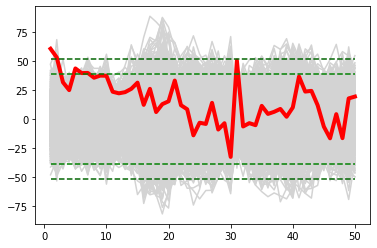

In [ ]:
ax = plt.gca()
numberofShuffle=1000
allshuffledifference=np.zeros((numberofShuffle,arrayforshuffling.shape[0]))
for i in range(numberofShuffle):
    randomindexes=np.random.randint(2,size=arrayforshuffling.shape[1])
    shuffledmeans=np.zeros((2,arrayforshuffling.shape[0]))
    for value in [0,1]:
        index=np.where(randomindexes==value)
        shuffledmeans[value,:]=np.mean(arrayforshuffling[:,index[0]],1)

    shuffledifference=np.diff(shuffledmeans,1,0)
    allshuffledifference[i,:]=shuffledifference[0,:]
    ax.plot(trialnumber,shuffledifference[0,:],color='lightgrey')
    
ax.plot(trialnumber,meandifference[0,:],color='red',linewidth=4)
globalconfidenceband1=np.percentile(allshuffledifference,[0.5,99.5])
globalconfidenceband5=np.percentile(allshuffledifference,[2.5,97.5])
for index in [1,0]:
    ax.plot([trialnumber[0],trialnumber[-1]],[globalconfidenceband1[index],globalconfidenceband1[index]],'darkgreen',linestyle="--")
    ax.plot([trialnumber[0],trialnumber[-1]],[globalconfidenceband5[index],globalconfidenceband5[index]],'green',linestyle="--")

        

[-0.6451708   0.08543255  1.01881542]
[567.23810459   8.7014004    1.04241974]


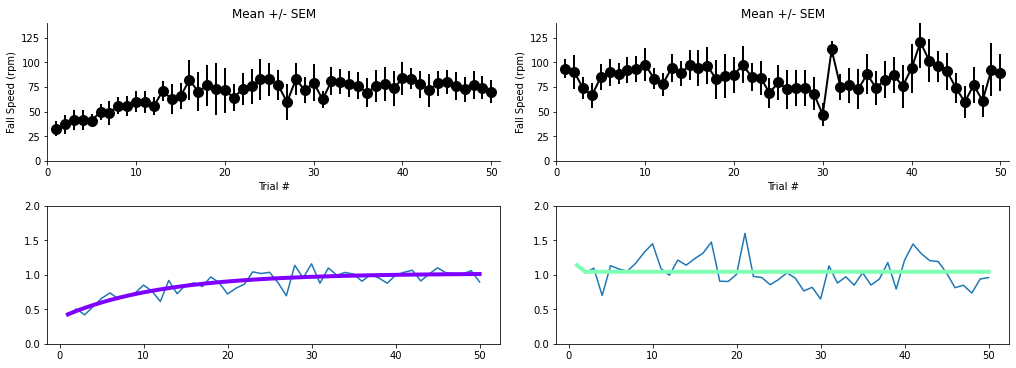

In [ ]:

from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(7*2, 5),
                        constrained_layout=True)

experimentsNames=['ACN_F','ACN_M']
experimentsNames=['ACN','Cst_4rpm']
numberoftrialstoplot=50
trialindex=np.arange(numberoftrialstoplot)
trialnumber=np.arange(1,numberoftrialstoplot+1)
normalizerealmean=np.zeros((2,numberoftrialstoplot))
alldata={}
for experimentindex, thisExperiment in enumerate(experimentsNames):

    alldata[thisExperiment]=pd.read_excel(dataFileName,sheet_name=thisExperiment,header=[2],index_col=0).values
  
    fallTimeDataThisExperiment=alldata[thisExperiment][:numberoftrialstoplot,:]
    #Classical plotting mean + SEM

    meanFallTime=np.nanmean(fallTimeDataThisExperiment,axis=1)
    semFallTime=np.nanstd(fallTimeDataThisExperiment,axis=1)/math.sqrt(numberofanimaldatapoints)
    axs[0,experimentindex].errorbar(trialnumber,meanFallTime,semFallTime,ecolor='k',elinewidth=2,color='k',linewidth=2,marker='o',ms=10)
    #axs[experimentindex].plot(trialnumber,np.nanmedian(alldata[thisExperiment][:,fallTimeColumnIndexes],axis=1),'k',linewidth=4)
    axs[0,experimentindex].set_ylim([0,140])
    axs[0,experimentindex].set_xlim([0,51])
    axs[0,experimentindex].set_title('Mean +/- SEM')
    axs[0,experimentindex].set_ylabel('Fall Speed (rpm)')
    axs[0,experimentindex].set_xlabel('Trial #')
    axs[0,experimentindex].spines['right'].set_visible(False)
    axs[0,experimentindex].spines['top'].set_visible(False)

    #Normalize data by the two last day median
    medianFallTimeLastTwentyTrials=np.median(fallTimeDataThisExperiment[30:,:],axis=0)
    normalizedFallTimeDataThisExperiment=np.divide(fallTimeDataThisExperiment,medianFallTimeLastTwentyTrials)
   


    xdata=trialnumber
    ydata=np.nanmedian(normalizedFallTimeDataThisExperiment,axis=1)
    normalizerealmean[experimentindex,:]=ydata
    popt, pcov = curve_fit(func, xdata, ydata)
    print(popt)
    axs[1,experimentindex].plot(trialnumber,np.nanmedian(normalizedFallTimeDataThisExperiment,axis=1))
    axs[1,experimentindex].plot(xdata, func(xdata, *popt), color=cm.rainbow(experimentindex/(len(experimentsNames))),linewidth=4,
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
    axs[1,experimentindex].set_ylim([0,2])

    #axs[0,experimentindex].set_xlim([trialnumber[0],trialnumber[-1]])
   

    

Text(0.5, 1.0, 'difference')

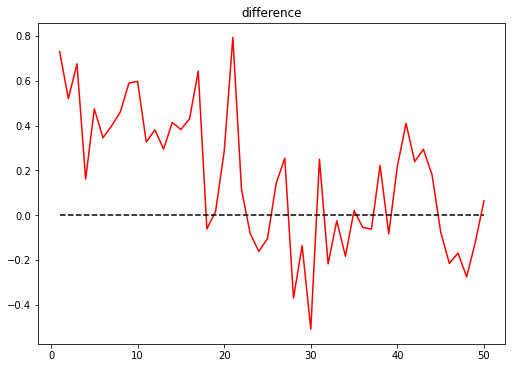

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(7*1, 5*1),
                        constrained_layout=True)




meandifferencenormalized=np.diff(normalizerealmean,1,0)
axs.plot(trialnumber ,meandifferencenormalized[0,:],color='red')
axs.plot([trialnumber[0],trialnumber[-1]],[0,0],'k',linestyle="--")
axs.set_title('difference')

In [ ]:
print(medianFallTimeLastTwentyTrials)

[ 55.5  53.5 172.5  55.5  63.  126.5  78.  101.   61.   24.   60.   63.
  55.5  87.   73.5  83.5 133.5 105.   10.5   2.   64.5 139.5  80.  108. ]


In [ ]:
arrayforshuffling=np.concatenate((alldata[experimentsNames[0]][:numberoftrialstoplot,:],alldata[experimentsNames[1]][:numberoftrialstoplot,:]),axis=1)
print(arrayforshuffling.shape)
medianFallTimeLastTwentyTrials=np.median(arrayforshuffling[30:,:],axis=0)
normalizedarrayforshuffling=np.divide(arrayforshuffling,medianFallTimeLastTwentyTrials)
#normalizedarrayforshuffling


(50, 24)


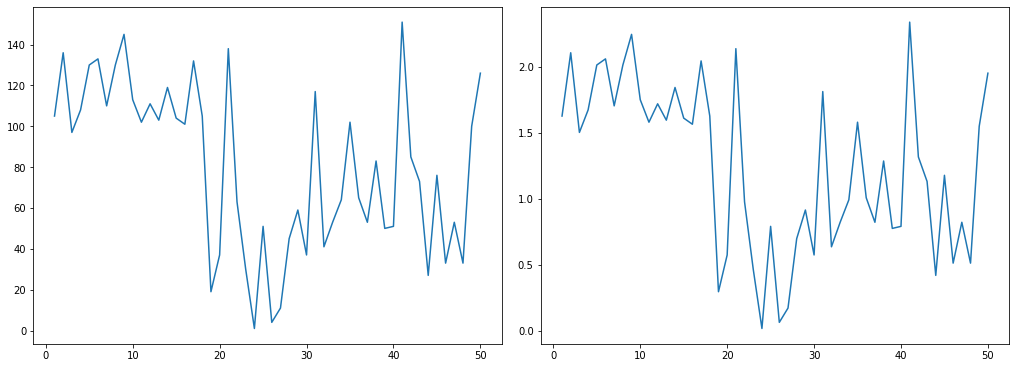

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7*2, 5*1),
                        constrained_layout=True)

animalnumber=20
axs[0].plot(trialnumber ,arrayforshuffling[:,animalnumber])
axs[1].plot(trialnumber ,normalizedarrayforshuffling[:,animalnumber])


In [ ]:
print(arrayforshuffling[:,0])

[0.55855856 0.54054054 0.55855856 0.28828829 0.43243243 0.73873874
 0.95495495 1.04504505 1.06306306 0.77477477 0.88288288 0.97297297
 1.47747748 0.45045045 1.33333333 3.45945946 1.26126126 1.42342342
 0.88288288 1.35135135 1.47747748 1.24324324 1.62162162 1.76576577
 1.22522523 0.84684685 0.32432432 1.38738739 0.95495495 0.01801802
 0.93693694 1.04504505 1.76576577 1.31531532 0.82882883 0.59459459
 0.7027027  0.54054054 0.3963964  1.11711712 1.92792793 0.97297297
 1.02702703 0.5045045  1.72972973 1.08108108 1.51351351 0.55855856
 1.63963964 0.41441441]


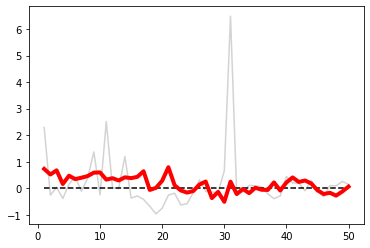

In [ ]:
randomindexes=np.random.randint(2,size=arrayforshuffling.shape[1])
shuffledmeans=np.zeros((2,arrayforshuffling.shape[0]))
for value in [0,1]:
    index=np.where(randomindexes==value)
    shuffledmeans[value,:]=np.mean(arrayforshuffling[:,index[0]],1)

shuffledifference=np.diff(shuffledmeans,1,0)
ax = plt.gca()
ax.plot(trialnumber,shuffledifference[0,:],color='lightgray')
ax.plot([trialnumber[0],trialnumber[-1]],[0,0],'k',linestyle="--")
ax.plot(trialnumber ,meandifferencenormalized[0,:],color='red',linewidth=4)

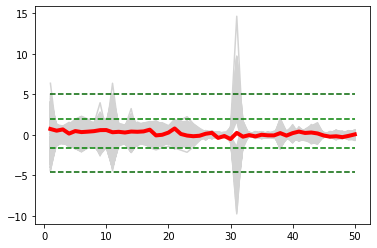

In [ ]:
ax = plt.gca()
numberofShuffle=1000
allshuffledifference=np.zeros((numberofShuffle,arrayforshuffling.shape[0]))
for i in range(numberofShuffle):
    randomindexes=np.random.randint(2,size=arrayforshuffling.shape[1])
    shuffledmeans=np.zeros((2,arrayforshuffling.shape[0]))
    for value in [0,1]:
        index=np.where(randomindexes==value)
        shuffledmeans[value,:]=np.mean(arrayforshuffling[:,index[0]],1)

    shuffledifference=np.diff(shuffledmeans,1,0)
    allshuffledifference[i,:]=shuffledifference[0,:]
    ax.plot(trialnumber,shuffledifference[0,:],color='lightgrey')
    
ax.plot(trialnumber,meandifferencenormalized[0,:],color='red',linewidth=4)
globalconfidenceband1=np.percentile(allshuffledifference,[0.5,99.5])
globalconfidenceband5=np.percentile(allshuffledifference,[2.5,97.5])
for index in [1,0]:
    ax.plot([trialnumber[0],trialnumber[-1]],[globalconfidenceband1[index],globalconfidenceband1[index]],'darkgreen',linestyle="--")
    ax.plot([trialnumber[0],trialnumber[-1]],[globalconfidenceband5[index],globalconfidenceband5[index]],'green',linestyle="--")

        

In [ ]:
normalizerealmean=np.zeros((2,numberoftrialstoplot))
for thisExperiment in experimentsNames:
  fallTimeDataThisExperiment=alldata[thisExperiment][:numberoftrialstoplot,:]
  medianFallTimeLastTwentyTrials=np.median(alldata[thisExperiment][30:50,:],axis=0)
  normalizedFallTimeDataThisExperiment=np.divide(fallTimeDataThisExperiment,medianFallTimeLastTwentyTrials)
  

  print(alldata[thisExperiment].shape[1])


16
8
